# Analisi Back Squat con Accelerometro

Questo notebook analizza i dati dell'accelerometro durante l'esecuzione di back squat, identificando automaticamente le diverse fasi del movimento:
- **Posizione iniziale (Standing)**
- **Fase eccentrica (Discesa)**
- **Posizione inferiore (Bottom)**
- **Fase concentrica (Salita)**

I dati vengono visualizzati con marker che indicano i cambiamenti di fase.

## 1. Import Librerie

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter1d

# Configurazione per grafici più grandi e leggibili
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Librerie importate con successo")

✅ Librerie importate con successo


## 2. Caricamento Dati

In [9]:
# Carica il file CSV
filename = 'accel_data_20251118_074755.csv'
df = pd.read_csv(filename)

# Mostra le prime righe
print(f"📊 Dataset caricato: {len(df)} campioni")
print(f"⏱️  Durata: {df['Timestamp'].max() - df['Timestamp'].min():.2f} secondi")
print(f"📈 Frequenza di campionamento: ~{len(df)/(df['Timestamp'].max() - df['Timestamp'].min()):.1f} Hz\n")

df.head(10)

📊 Dataset caricato: 252 campioni
⏱️  Durata: 4.96 secondi
📈 Frequenza di campionamento: ~50.8 Hz



,Timestamp,X (g),Y (g),Z (g),Magnitude (g)
0,17.705,0.093750,-0.890625,0.343750,0.959253
1,17.707,0.093750,-0.890625,0.328125,0.953765
2,17.712,0.093750,-0.890625,0.312500,0.948503
3,17.712,0.093750,-0.906250,0.328125,0.968372
4,17.712,0.093750,-0.890625,0.328125,0.953765
5,17.746,0.093750,-0.890625,0.328125,0.953765
6,17.785,0.109375,-0.906250,0.328125,0.970009
7,17.785,0.109375,-0.890625,0.328125,0.955428
8,17.788,0.125000,-0.890625,0.343750,0.962809
9,17.841,0.109375,-0.906250,0.343750,0.975406


## 3. Visualizzazione Dati Grezzi

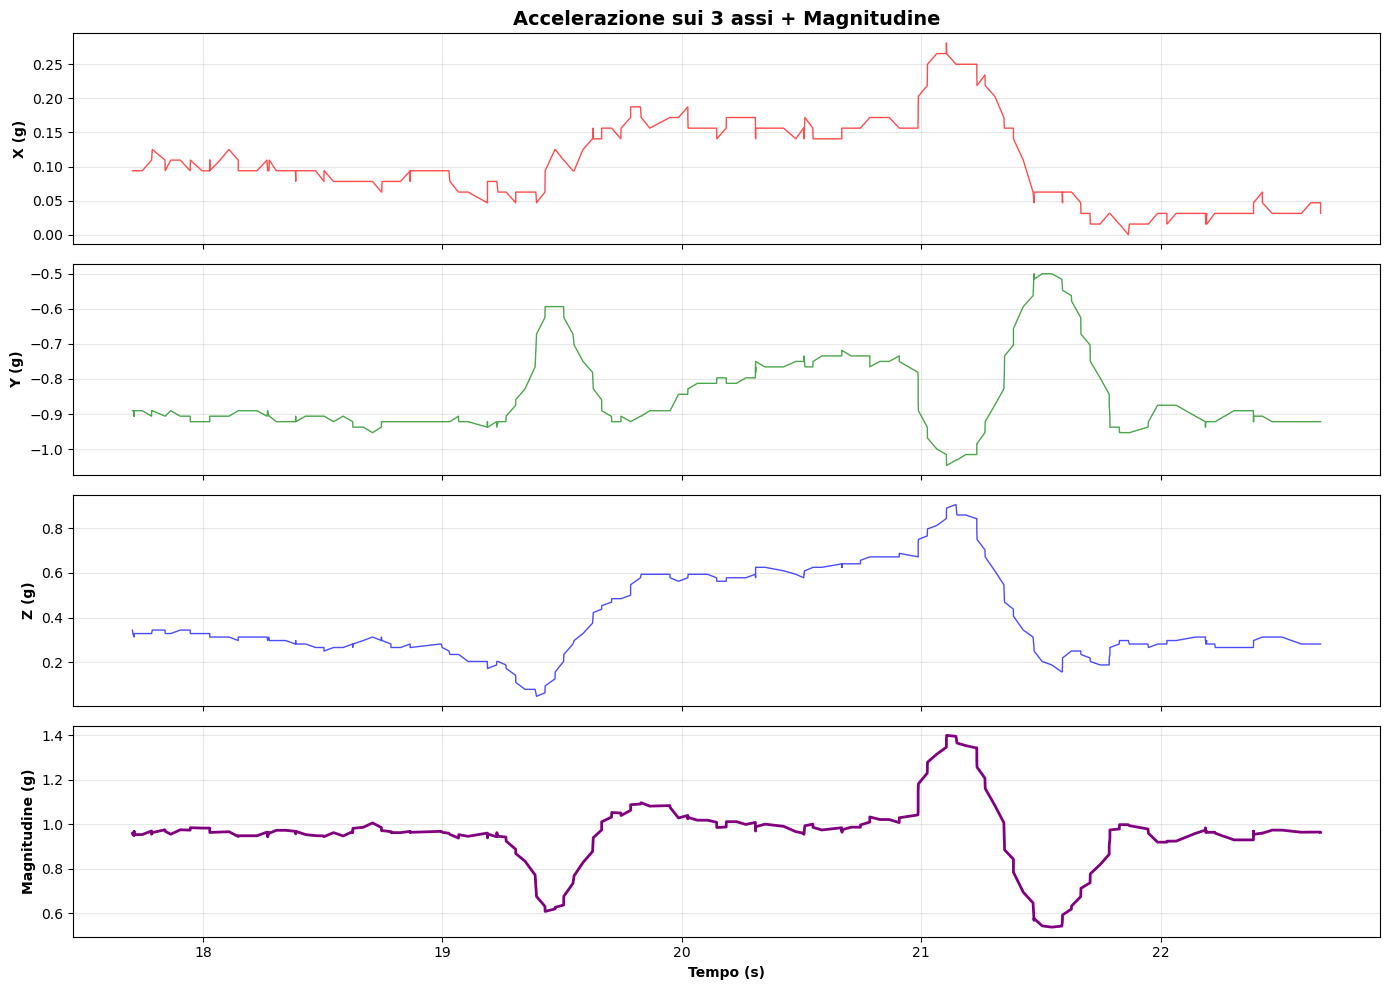

In [10]:
# Plot dei dati grezzi
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df['Timestamp'], df['X (g)'], 'r-', alpha=0.7, linewidth=1)
axes[0].set_ylabel('X (g)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Accelerazione sui 3 assi + Magnitudine', fontsize=14, fontweight='bold')

axes[1].plot(df['Timestamp'], df['Y (g)'], 'g-', alpha=0.7, linewidth=1)
axes[1].set_ylabel('Y (g)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['Timestamp'], df['Z (g)'], 'b-', alpha=0.7, linewidth=1)
axes[2].set_ylabel('Z (g)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

axes[3].plot(df['Timestamp'], df['Magnitude (g)'], 'purple', linewidth=2)
axes[3].set_ylabel('Magnitudine (g)', fontweight='bold')
axes[3].set_xlabel('Tempo (s)', fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Smoothing e Preprocessing

In [11]:
# Applica smoothing gaussiano per ridurre il rumore
sigma = 2  # Parametro di smoothing

df['X_smooth'] = gaussian_filter1d(df['X (g)'], sigma=sigma)
df['Y_smooth'] = gaussian_filter1d(df['Y (g)'], sigma=sigma)
df['Z_smooth'] = gaussian_filter1d(df['Z (g)'], sigma=sigma)
df['Mag_smooth'] = gaussian_filter1d(df['Magnitude (g)'], sigma=sigma)

# Calcola la derivata (velocità) della magnitudine per identificare cambiamenti
df['Mag_velocity'] = np.gradient(df['Mag_smooth'], df['Timestamp'])
df['Mag_velocity_smooth'] = gaussian_filter1d(df['Mag_velocity'], sigma=sigma)

print("✅ Smoothing applicato")

✅ Smoothing applicato


c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1309: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1309: RuntimeWarning: invalid value encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1310: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1310: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1311: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1311: RuntimeWarning: invalid value encountered in divide
  c

## 5. Rilevamento Fasi dello Squat

L'algoritmo identifica l'**inizio** di ogni fase del back squat:
1. **Baseline** - Posizione iniziale in piedi (stabile)
2. **Eccentrica** - Inizio discesa (accelerazione negativa su Y)
3. **Concentrica** - Inizio spinta verso l'alto (punto più basso + cambio direzione)
4. **Arresto** - Fine movimento (decelerazione vicino al top)
5. **Baseline** - Ritorno alla stabilità

In [12]:
# Identificazione delle 5 fasi del back squat
# Useremo la magnitudine e l'asse Y (verticale) per identificare le transizioni

mag = df['Mag_smooth'].values
y_acc = df['Y_smooth'].values
timestamps = df['Timestamp'].values

# Calcola la velocità (derivata) della magnitudine
mag_velocity = np.gradient(mag, timestamps)
mag_velocity_smooth = gaussian_filter1d(mag_velocity, sigma=3)

# Trova tutti i punti di interesse
min_distance = 30  # Distanza minima tra eventi (campioni)

# 1. Trova i minimi locali (bottom = inizio fase concentrica)
inverted_mag = -mag
bottoms, _ = signal.find_peaks(inverted_mag, distance=min_distance, prominence=0.05)

# 2. Trova i massimi di magnitudine (picchi di accelerazione)
peaks, _ = signal.find_peaks(mag, distance=min_distance, prominence=0.1)

# 3. Trova i cambi di direzione della velocità
velocity_sign = np.sign(mag_velocity_smooth)
velocity_changes = np.where(np.diff(velocity_sign) != 0)[0]

# Identifica le fasi per ogni ripetizione
phases = []

for i, bottom_idx in enumerate(bottoms):
    rep_phases = {'rep': i + 1}
    
    # Baseline iniziale: cerca stabilità prima della discesa
    baseline_start = 0 if i == 0 else bottoms[i-1] + 20
    stable_region = np.where((mag[baseline_start:bottom_idx] > 0.9) & (mag[baseline_start:bottom_idx] < 1.0))[0]
    if len(stable_region) > 0:
        rep_phases['baseline_1'] = baseline_start + stable_region[0]
    else:
        rep_phases['baseline_1'] = baseline_start
    
    # Fase eccentrica: primo punto dove la magnitudine inizia ad aumentare significativamente
    mag_slice = mag[:bottom_idx]
    indices_slice = np.arange(len(mag_slice))
    eccentric_candidates = np.where((mag_slice > mag[rep_phases['baseline_1']] + 0.05) & 
                                    (indices_slice > rep_phases['baseline_1']))[0]
    rep_phases['eccentric'] = eccentric_candidates[0] if len(eccentric_candidates) > 0 else rep_phases['baseline_1'] + 10
    
    # Fase concentrica: il bottom (punto più basso)
    rep_phases['concentric'] = bottom_idx
    
    # Arresto: cerca il picco dopo il bottom (decelerazione)
    peaks_after_bottom = peaks[peaks > bottom_idx]
    if len(peaks_after_bottom) > 0:
        rep_phases['arrest'] = peaks_after_bottom[0]
    else:
        rep_phases['arrest'] = bottom_idx + int((len(df) - bottom_idx) * 0.5)
    
    # Baseline finale: ritorno a stabilità dopo l'arresto
    baseline_end = rep_phases['arrest'] + 10
    if baseline_end < len(mag):
        stable_after = np.where((mag[baseline_end:] > 0.9) & (mag[baseline_end:] < 1.0))[0]
        rep_phases['baseline_2'] = baseline_end + stable_after[0] if len(stable_after) > 0 else baseline_end
    else:
        rep_phases['baseline_2'] = min(baseline_end, len(mag) - 1)
    
    phases.append(rep_phases)

print(f"🔍 Identificate {len(phases)} ripetizioni complete")
print(f"📍 Fasi per ripetizione: Baseline → Eccentrica → Concentrica → Arresto → Baseline")

# Mostra i dettagli
for phase in phases:
    print(f"\n🏋️ Ripetizione {phase['rep']}:")
    print(f"   Baseline iniziale: t={timestamps[phase['baseline_1']]:.2f}s")
    print(f"   Eccentrica (discesa): t={timestamps[phase['eccentric']]:.2f}s")
    print(f"   Concentrica (spinta): t={timestamps[phase['concentric']]:.2f}s")
    print(f"   Arresto: t={timestamps[phase['arrest']]:.2f}s")
    print(f"   Baseline finale: t={timestamps[phase['baseline_2']]:.2f}s")

🔍 Identificate 3 ripetizioni complete
📍 Fasi per ripetizione: Baseline → Eccentrica → Concentrica → Arresto → Baseline

🏋️ Ripetizione 1:
   Baseline iniziale: t=17.70s
   Eccentrica (discesa): t=17.84s
   Concentrica (spinta): t=19.47s
   Arresto: t=19.83s
   Baseline finale: t=20.15s

🏋️ Ripetizione 2:
   Baseline iniziale: t=20.15s
   Eccentrica (discesa): t=20.35s
   Concentrica (spinta): t=20.51s
   Arresto: t=21.14s
   Baseline finale: t=21.35s

🏋️ Ripetizione 3:
   Baseline iniziale: t=21.35s
   Eccentrica (discesa): t=21.59s
   Concentrica (spinta): t=21.55s
   Arresto: t=22.19s
   Baseline finale: t=22.31s


c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1309: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1309: RuntimeWarning: invalid value encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1310: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1310: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1311: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\UserDemo\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1311: RuntimeWarning: invalid value encountered in divide
  c

## 6. Visualizzazione con Marker delle Fasi

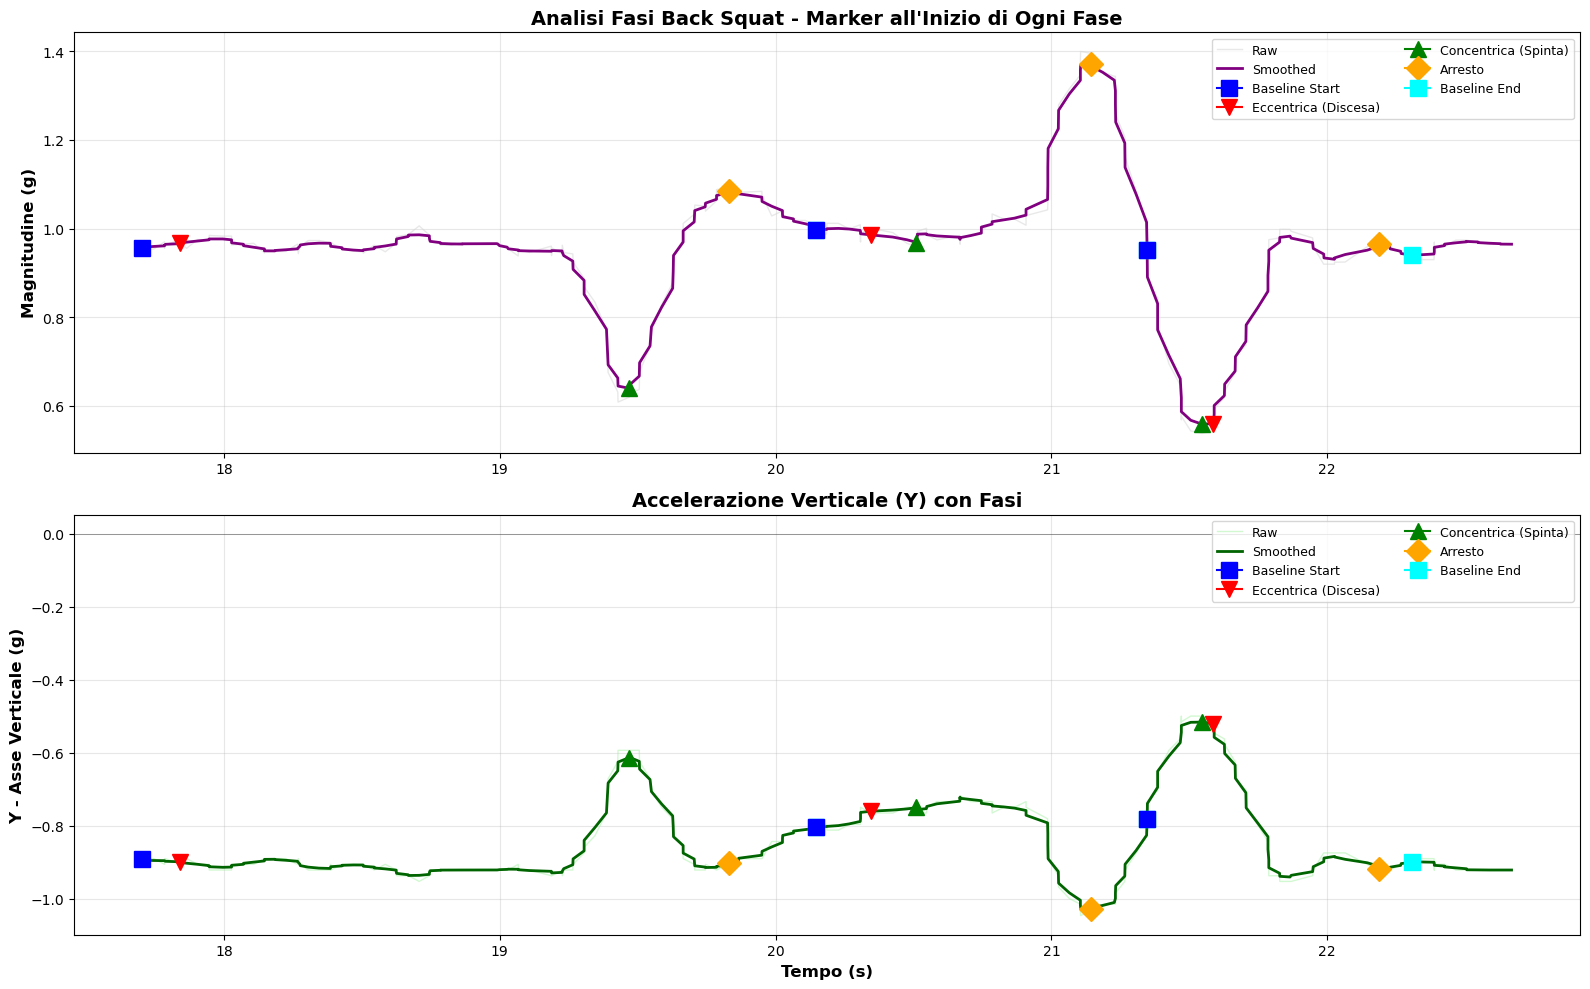

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Magnitudine con marker delle fasi
ax1 = axes[0]
ax1.plot(df['Timestamp'], df['Magnitude (g)'], 'lightgray', alpha=0.5, linewidth=1, label='Raw')
ax1.plot(df['Timestamp'], df['Mag_smooth'], 'purple', linewidth=2, label='Smoothed')

# Marker per tutte le fasi
colors = {
    'baseline_1': ('blue', 's', 'Baseline Start'),
    'eccentric': ('red', 'v', 'Eccentrica (Discesa)'),
    'concentric': ('green', '^', 'Concentrica (Spinta)'),
    'arrest': ('orange', 'D', 'Arresto'),
    'baseline_2': ('cyan', 's', 'Baseline End')
}

for phase in phases:
    for phase_name, (color, marker, label) in colors.items():
        if phase_name in phase:
            idx = phase[phase_name]
            # Plot marker solo per la prima ripetizione per evitare duplicati nella legenda
            if phase['rep'] == 1:
                ax1.plot(df.iloc[idx]['Timestamp'], df.iloc[idx]['Mag_smooth'], 
                        marker=marker, color=color, markersize=12, label=label, zorder=5)
            else:
                ax1.plot(df.iloc[idx]['Timestamp'], df.iloc[idx]['Mag_smooth'], 
                        marker=marker, color=color, markersize=12, zorder=5)

ax1.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=12)
ax1.set_title('Analisi Fasi Back Squat - Marker all\'Inizio di Ogni Fase', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=9, ncol=2)

# Plot 2: Asse Y (verticale) con marker
ax2 = axes[1]
ax2.plot(df['Timestamp'], df['Y (g)'], 'lightgreen', alpha=0.4, linewidth=1, label='Raw')
ax2.plot(df['Timestamp'], df['Y_smooth'], 'darkgreen', linewidth=2, label='Smoothed')

# Marker per tutte le fasi sull'asse Y
for phase in phases:
    for phase_name, (color, marker, label) in colors.items():
        if phase_name in phase:
            idx = phase[phase_name]
            if phase['rep'] == 1:
                ax2.plot(df.iloc[idx]['Timestamp'], df.iloc[idx]['Y_smooth'], 
                        marker=marker, color=color, markersize=12, label=label, zorder=5)
            else:
                ax2.plot(df.iloc[idx]['Timestamp'], df.iloc[idx]['Y_smooth'], 
                        marker=marker, color=color, markersize=12, zorder=5)

ax2.set_xlabel('Tempo (s)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Y - Asse Verticale (g)', fontweight='bold', fontsize=12)
ax2.set_title('Accelerazione Verticale (Y) con Fasi', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=9, ncol=2)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

## 7. Grafico Multi-Asse Completo

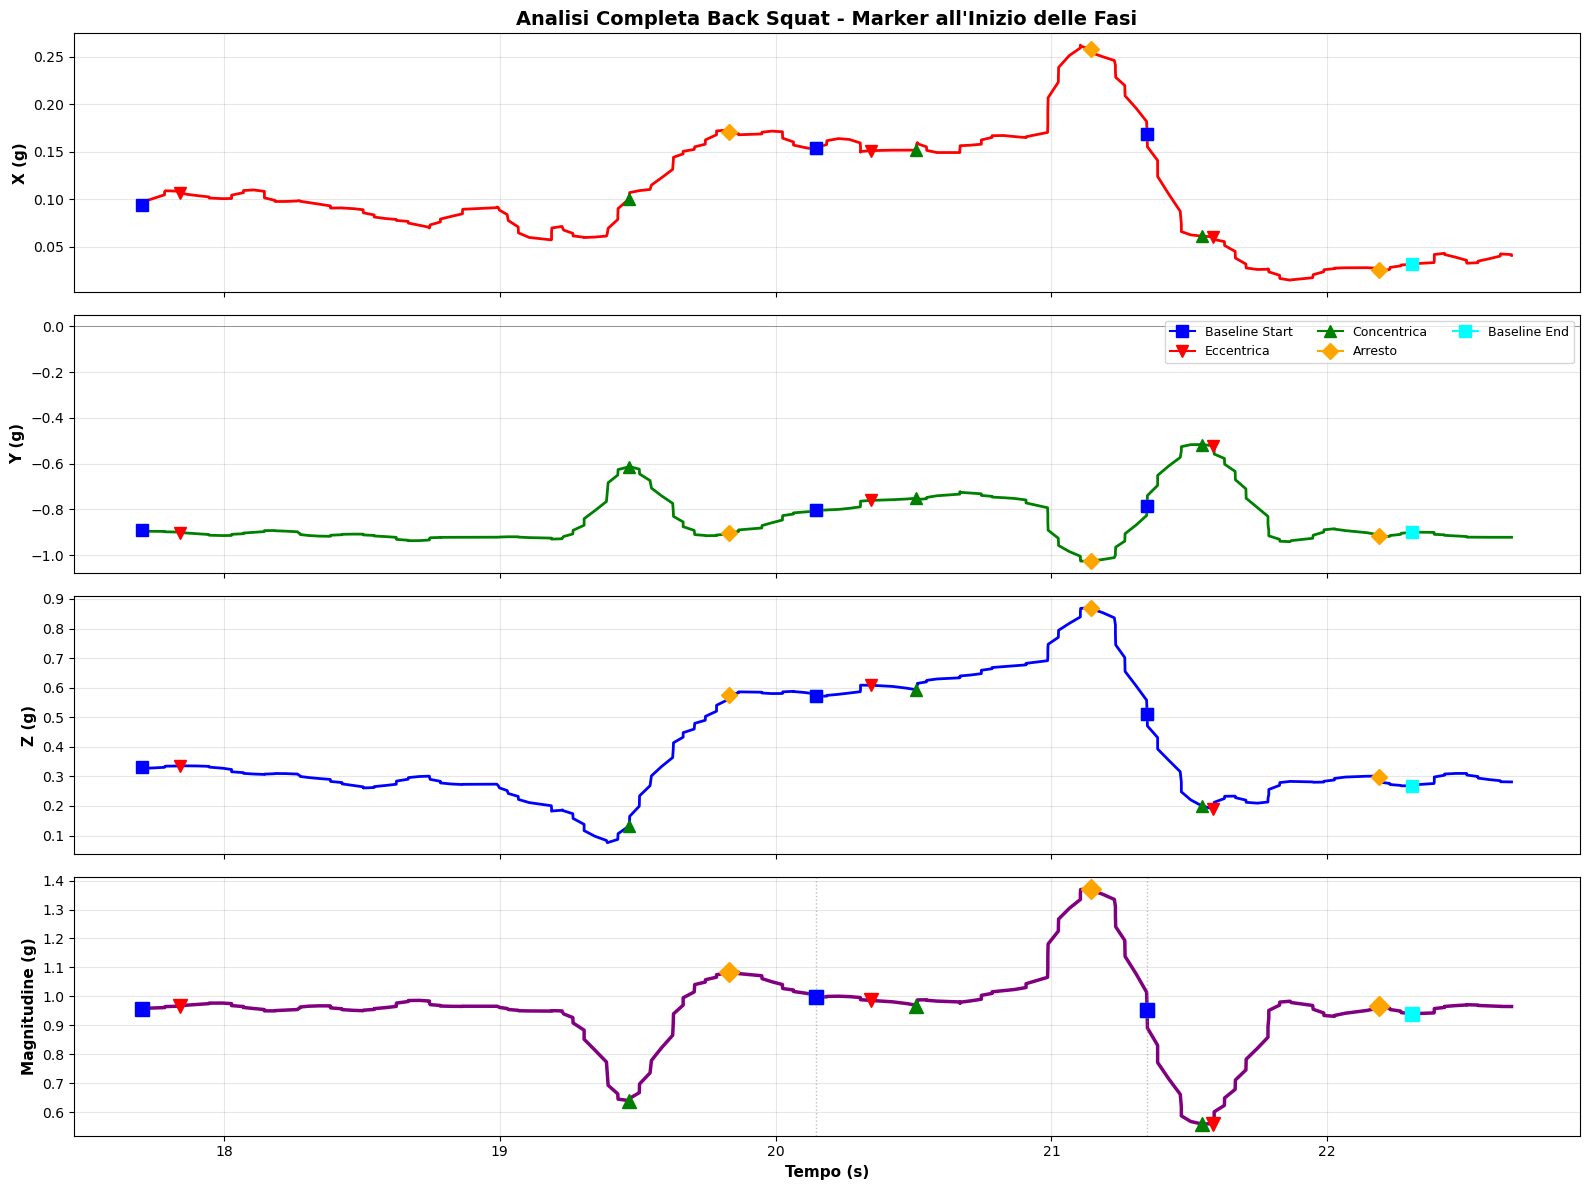

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Definizione marker
colors = {
    'baseline_1': ('blue', 's', 'Baseline Start'),
    'eccentric': ('red', 'v', 'Eccentrica'),
    'concentric': ('green', '^', 'Concentrica'),
    'arrest': ('orange', 'D', 'Arresto'),
    'baseline_2': ('cyan', 's', 'Baseline End')
}

# X axis
axes[0].plot(df['Timestamp'], df['X_smooth'], 'r-', linewidth=2)
for phase in phases:
    for phase_name, (color, marker, _) in colors.items():
        if phase_name in phase:
            idx = phase[phase_name]
            axes[0].plot(df.iloc[idx]['Timestamp'], df.iloc[idx]['X_smooth'], 
                        marker=marker, color=color, markersize=8)
axes[0].set_ylabel('X (g)', fontweight='bold', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Analisi Completa Back Squat - Marker all\'Inizio delle Fasi', fontsize=14, fontweight='bold')

# Y axis (verticale)
axes[1].plot(df['Timestamp'], df['Y_smooth'], 'g-', linewidth=2)
for phase in phases:
    for phase_name, (color, marker, label) in colors.items():
        if phase_name in phase:
            idx = phase[phase_name]
            if phase['rep'] == 1:  # Legenda solo per prima ripetizione
                axes[1].plot(df.iloc[idx]['Timestamp'], df.iloc[idx]['Y_smooth'], 
                            marker=marker, color=color, markersize=8, label=label)
            else:
                axes[1].plot(df.iloc[idx]['Timestamp'], df.iloc[idx]['Y_smooth'], 
                            marker=marker, color=color, markersize=8)
axes[1].set_ylabel('Y (g)', fontweight='bold', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right', fontsize=9, ncol=3)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# Z axis
axes[2].plot(df['Timestamp'], df['Z_smooth'], 'b-', linewidth=2)
for phase in phases:
    for phase_name, (color, marker, _) in colors.items():
        if phase_name in phase:
            idx = phase[phase_name]
            axes[2].plot(df.iloc[idx]['Timestamp'], df.iloc[idx]['Z_smooth'], 
                        marker=marker, color=color, markersize=8)
axes[2].set_ylabel('Z (g)', fontweight='bold', fontsize=11)
axes[2].grid(True, alpha=0.3)

# Magnitude
axes[3].plot(df['Timestamp'], df['Mag_smooth'], 'purple', linewidth=2.5)
for phase in phases:
    for phase_name, (color, marker, _) in colors.items():
        if phase_name in phase:
            idx = phase[phase_name]
            axes[3].plot(df.iloc[idx]['Timestamp'], df.iloc[idx]['Mag_smooth'], 
                        marker=marker, color=color, markersize=10, zorder=5)
            # Linea verticale per separare le ripetizioni
            if phase_name == 'baseline_1' and phase['rep'] > 1:
                axes[3].axvline(x=df.iloc[idx]['Timestamp'], color='gray', 
                               linestyle=':', alpha=0.5, linewidth=1)

axes[3].set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=11)
axes[3].set_xlabel('Tempo (s)', fontweight='bold', fontsize=11)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Analisi Statistica delle Ripetizioni

In [15]:
# Analizza ogni ripetizione identificata
if len(phases) > 0:
    print(f"\n📊 ANALISI DETTAGLIATA RIPETIZIONI SQUAT")
    print("=" * 100)
    
    squat_data = []
    
    for phase in phases:
        rep_num = phase['rep']
        
        # Timestamp di ogni fase
        t_baseline1 = df.iloc[phase['baseline_1']]['Timestamp']
        t_eccentric = df.iloc[phase['eccentric']]['Timestamp']
        t_concentric = df.iloc[phase['concentric']]['Timestamp']
        t_arrest = df.iloc[phase['arrest']]['Timestamp']
        t_baseline2 = df.iloc[phase['baseline_2']]['Timestamp']
        
        # Calcola durate delle fasi
        eccentric_duration = t_concentric - t_eccentric  # Tempo di discesa
        concentric_duration = t_arrest - t_concentric     # Tempo di spinta
        total_rep_time = t_baseline2 - t_baseline1        # Tempo totale ripetizione
        
        # Valori di accelerazione
        mag_baseline1 = df.iloc[phase['baseline_1']]['Mag_smooth']
        mag_eccentric = df.iloc[phase['eccentric']]['Mag_smooth']
        mag_concentric = df.iloc[phase['concentric']]['Mag_smooth']
        mag_arrest = df.iloc[phase['arrest']]['Mag_smooth']
        mag_baseline2 = df.iloc[phase['baseline_2']]['Mag_smooth']
        
        squat_data.append({
            'Rep': rep_num,
            'Baseline Start (s)': f"{t_baseline1:.2f}",
            'Eccentrica Start (s)': f"{t_eccentric:.2f}",
            'Concentrica Start (s)': f"{t_concentric:.2f}",
            'Arresto (s)': f"{t_arrest:.2f}",
            'Baseline End (s)': f"{t_baseline2:.2f}",
            'Durata Eccentrica (s)': f"{eccentric_duration:.2f}",
            'Durata Concentrica (s)': f"{concentric_duration:.2f}",
            'Tempo Totale (s)': f"{total_rep_time:.2f}",
            'Mag Bottom (g)': f"{mag_concentric:.3f}",
            'Mag Peak (g)': f"{mag_arrest:.3f}"
        })
    
    # Crea DataFrame per visualizzazione
    squat_df = pd.DataFrame(squat_data)
    print(squat_df.to_string(index=False))
    print("=" * 100)
    
    # Statistiche generali
    print(f"\n📈 STATISTICHE GENERALI")
    print(f"   Numero ripetizioni: {len(phases)}")
    
    eccentric_times = [float(d['Durata Eccentrica (s)']) for d in squat_data]
    concentric_times = [float(d['Durata Concentrica (s)']) for d in squat_data]
    
    print(f"   Durata media fase eccentrica: {np.mean(eccentric_times):.2f}s (±{np.std(eccentric_times):.2f}s)")
    print(f"   Durata media fase concentrica: {np.mean(concentric_times):.2f}s (±{np.std(concentric_times):.2f}s)")
    print(f"   Ratio eccentrica/concentrica: {np.mean(eccentric_times)/np.mean(concentric_times):.2f}")
    
else:
    print("⚠️ Nessuna ripetizione completa rilevata nel dataset")


📊 ANALISI DETTAGLIATA RIPETIZIONI SQUAT
 Rep Baseline Start (s) Eccentrica Start (s) Concentrica Start (s) Arresto (s) Baseline End (s) Durata Eccentrica (s) Durata Concentrica (s) Tempo Totale (s) Mag Bottom (g) Mag Peak (g)
   1              17.70                17.84                 19.47       19.83            20.15                  1.63                   0.36             2.44          0.639        1.084
   2              20.15                20.35                 20.51       21.14            21.35                  0.16                   0.64             1.20          0.967        1.371
   3              21.35                21.59                 21.55       22.19            22.31                 -0.04                   0.64             0.96          0.559        0.966

📈 STATISTICHE GENERALI
   Numero ripetizioni: 3
   Durata media fase eccentrica: 0.58s (±0.74s)
   Durata media fase concentrica: 0.55s (±0.13s)
   Ratio eccentrica/concentrica: 1.07


## 8b. Calcolo Mean Velocity (VBT - Velocity Based Training)


🚀 VELOCITY BASED TRAINING (VBT) - MEAN VELOCITY
 Rep Mean Velocity (m/s) Peak Velocity (m/s) Durata Concentrica (s) Displacement (m) Power Indicator
   1               1.338               2.842                   0.36            0.474            3.72
   2               2.067               5.025                   0.64            1.504            3.25
   3               2.016               5.148                   0.64            1.523            3.14

📊 STATISTICHE VBT
   Mean Velocity media: 1.807 m/s (±0.332 m/s)
   Peak Velocity media: 4.338 m/s (±1.059 m/s)

💡 NOTE:
   - Velocità calcolata dalla fase concentrica (spinta verso l'alto)
   - Mean Velocity è la metrica principale del VBT
   - Valori tipici back squat: 0.3-0.6 m/s (carico alto), 0.6-1.0 m/s (carico medio)
   - Power Indicator = Mean Velocity / Tempo (indica esplosività)


C:\Users\UserDemo\AppData\Local\Temp\ipykernel_712\1089366864.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  displacement = np.trapz(np.abs(velocity), time_concentric)


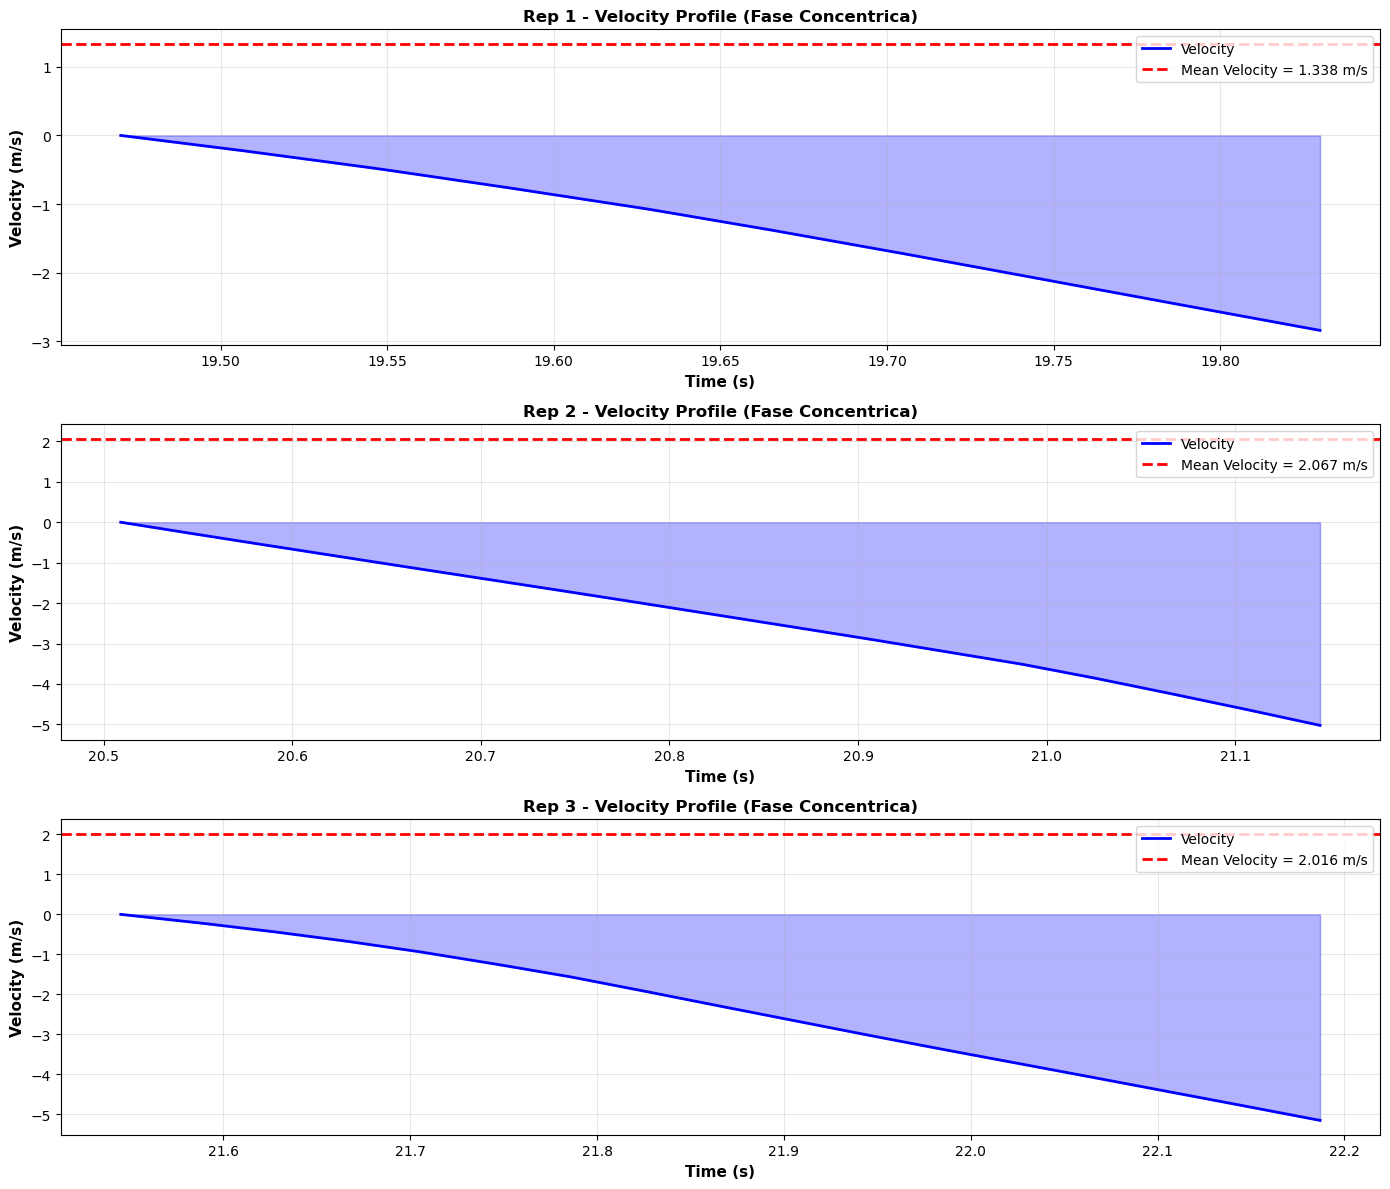


✅ Analisi VBT completata per 3 ripetizioni


In [17]:
# Calcolo della Mean Velocity per ogni ripetizione
# Nel VBT, la velocità media è calcolata integrando l'accelerazione verticale (asse Y)
# durante la fase concentrica (spinta verso l'alto)

print(f"\n🚀 VELOCITY BASED TRAINING (VBT) - MEAN VELOCITY")
print("=" * 100)

vbt_data = []

for phase in phases:
    rep_num = phase['rep']
    
    # Estrai la fase concentrica (dalla posizione più bassa fino all'arresto)
    start_idx = phase['concentric']
    end_idx = phase['arrest']
    
    # Dati della fase concentrica
    time_concentric = timestamps[start_idx:end_idx+1]
    y_accel_concentric = y_acc[start_idx:end_idx+1]
    
    # Rimuovi la gravità (assumendo che l'asse Y è verticale e 1g = gravità)
    # In posizione statica, Y dovrebbe essere ~0g se il sensore è orientato correttamente
    # L'accelerazione netta è quella che causa il movimento
    y_accel_net = y_accel_concentric * 9.81  # Converti da g a m/s²
    
    # Integra l'accelerazione per ottenere la velocità
    # Usa integrazione trapezoidale
    dt = np.diff(time_concentric)
    velocity = np.zeros(len(y_accel_net))
    
    for i in range(1, len(velocity)):
        # Integrazione trapezoidale: v[i] = v[i-1] + (a[i-1] + a[i])/2 * dt
        velocity[i] = velocity[i-1] + (y_accel_net[i-1] + y_accel_net[i]) / 2 * dt[i-1]
    
    # Mean Velocity: media della velocità durante la fase concentrica
    mean_velocity = np.mean(np.abs(velocity))
    
    # Peak Velocity: massima velocità raggiunta
    peak_velocity = np.max(np.abs(velocity))
    
    # Durata fase concentrica
    concentric_duration = time_concentric[-1] - time_concentric[0]
    
    # Displacement (spostamento) stimato: integrale della velocità
    displacement = np.trapz(np.abs(velocity), time_concentric)
    
    vbt_data.append({
        'Rep': rep_num,
        'Mean Velocity (m/s)': f"{mean_velocity:.3f}",
        'Peak Velocity (m/s)': f"{peak_velocity:.3f}",
        'Durata Concentrica (s)': f"{concentric_duration:.2f}",
        'Displacement (m)': f"{displacement:.3f}",
        'Power Indicator': f"{mean_velocity / concentric_duration:.2f}" if concentric_duration > 0 else "N/A"
    })

# Crea DataFrame VBT
vbt_df = pd.DataFrame(vbt_data)
print(vbt_df.to_string(index=False))
print("=" * 100)

# Statistiche VBT
mean_velocities = [float(d['Mean Velocity (m/s)']) for d in vbt_data]
peak_velocities = [float(d['Peak Velocity (m/s)']) for d in vbt_data]

print(f"\n📊 STATISTICHE VBT")
print(f"   Mean Velocity media: {np.mean(mean_velocities):.3f} m/s (±{np.std(mean_velocities):.3f} m/s)")
print(f"   Peak Velocity media: {np.mean(peak_velocities):.3f} m/s (±{np.std(peak_velocities):.3f} m/s)")
print(f"\n💡 NOTE:")
print(f"   - Velocità calcolata dalla fase concentrica (spinta verso l'alto)")
print(f"   - Mean Velocity è la metrica principale del VBT")
print(f"   - Valori tipici back squat: 0.3-0.6 m/s (carico alto), 0.6-1.0 m/s (carico medio)")
print(f"   - Power Indicator = Mean Velocity / Tempo (indica esplosività)")

# Visualizza profilo velocità per ogni ripetizione
fig, axes = plt.subplots(len(phases), 1, figsize=(14, 4*len(phases)), sharex=False)
if len(phases) == 1:
    axes = [axes]

for idx, phase in enumerate(phases):
    rep_num = phase['rep']
    start_idx = phase['concentric']
    end_idx = phase['arrest']
    
    time_concentric = timestamps[start_idx:end_idx+1]
    y_accel_concentric = y_acc[start_idx:end_idx+1]
    y_accel_net = y_accel_concentric * 9.81
    
    # Ricalcola velocità per il plot
    dt = np.diff(time_concentric)
    velocity = np.zeros(len(y_accel_net))
    for i in range(1, len(velocity)):
        velocity[i] = velocity[i-1] + (y_accel_net[i-1] + y_accel_net[i]) / 2 * dt[i-1]
    
    # Plot
    ax = axes[idx]
    ax.plot(time_concentric, velocity, 'b-', linewidth=2, label='Velocity')
    ax.axhline(y=float(vbt_data[idx]['Mean Velocity (m/s)']), color='red', 
               linestyle='--', linewidth=2, label=f"Mean Velocity = {vbt_data[idx]['Mean Velocity (m/s)']} m/s")
    ax.fill_between(time_concentric, 0, velocity, alpha=0.3, color='blue')
    
    ax.set_ylabel('Velocity (m/s)', fontweight='bold', fontsize=11)
    ax.set_xlabel('Time (s)', fontweight='bold', fontsize=11)
    ax.set_title(f'Rep {rep_num} - Velocity Profile (Fase Concentrica)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n✅ Analisi VBT completata per {len(phases)} ripetizioni")

## 9. Visualizzazione 3D della Traiettoria

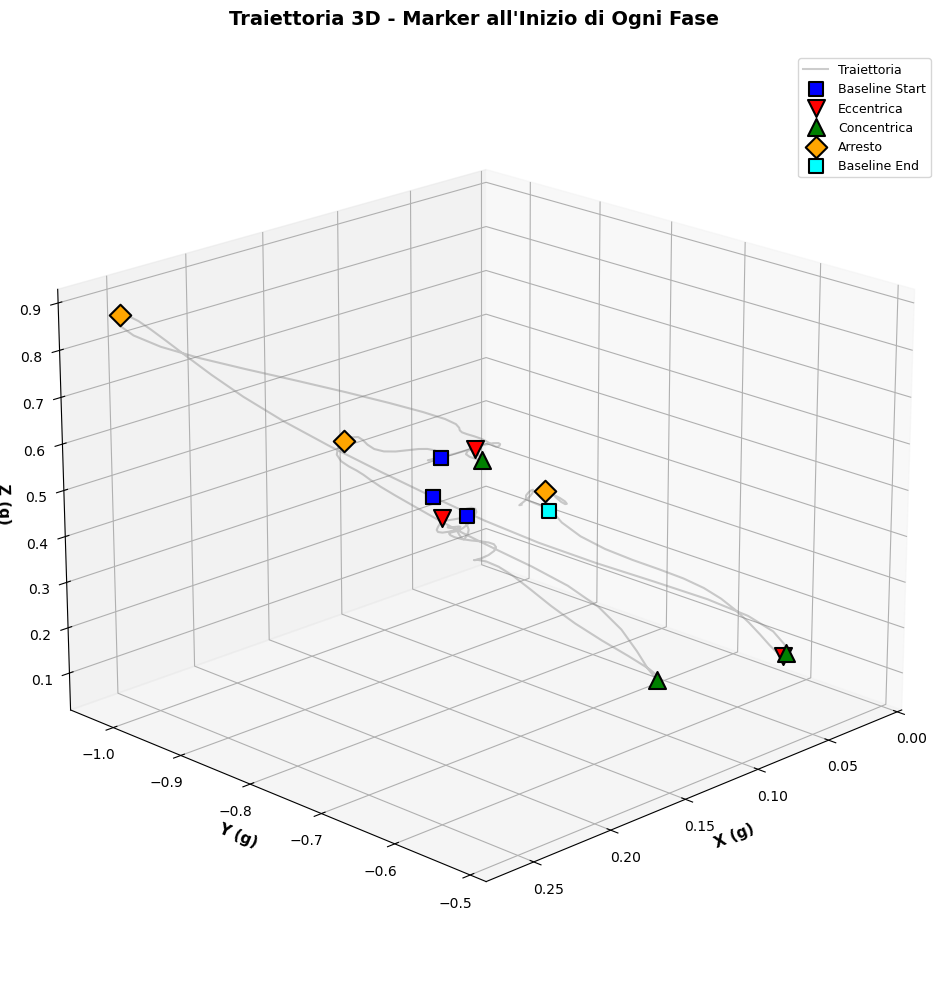

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot della traiettoria 3D
ax.plot(df['X_smooth'], df['Y_smooth'], df['Z_smooth'], 
        'gray', linewidth=1.5, alpha=0.4, label='Traiettoria')

# Marker per ogni fase
colors = {
    'baseline_1': ('blue', 's', 100, 'Baseline Start'),
    'eccentric': ('red', 'v', 150, 'Eccentrica'),
    'concentric': ('green', '^', 150, 'Concentrica'),
    'arrest': ('orange', 'D', 120, 'Arresto'),
    'baseline_2': ('cyan', 's', 100, 'Baseline End')
}

for phase in phases:
    for phase_name, (color, marker, size, label) in colors.items():
        if phase_name in phase:
            idx = phase[phase_name]
            if phase['rep'] == 1:  # Legenda solo per prima ripetizione
                ax.scatter(df.iloc[idx]['X_smooth'], 
                          df.iloc[idx]['Y_smooth'], 
                          df.iloc[idx]['Z_smooth'],
                          c=color, s=size, marker=marker, edgecolors='black', linewidths=1.5,
                          label=label, zorder=5)
            else:
                ax.scatter(df.iloc[idx]['X_smooth'], 
                          df.iloc[idx]['Y_smooth'], 
                          df.iloc[idx]['Z_smooth'],
                          c=color, s=size, marker=marker, edgecolors='black', linewidths=1.5,
                          zorder=5)

ax.set_xlabel('X (g)', fontweight='bold', fontsize=11)
ax.set_ylabel('Y (g)', fontweight='bold', fontsize=11)
ax.set_zlabel('Z (g)', fontweight='bold', fontsize=11)
ax.set_title('Traiettoria 3D - Marker all\'Inizio di Ogni Fase', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Imposta vista ottimale
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

## 10. Riepilogo e Conclusioni

Questo notebook ha analizzato i dati dell'accelerometro durante l'esecuzione di back squat identificando le **5 fasi** del movimento:

### Fasi Identificate:
1. 🟦 **Baseline Start** - Posizione iniziale stabile in piedi
2. 🔴 **Eccentrica** - Inizio della discesa (fase negativa)
3. 🟢 **Concentrica** - Inizio della spinta verso l'alto (punto più basso)
4. 🟠 **Arresto** - Decelerazione e fine del movimento verso l'alto
5. 🔵 **Baseline End** - Ritorno alla posizione stabile

### Marker sui Grafici:
- **Quadrati blu** (□) = Baseline
- **Triangoli rossi giù** (▼) = Inizio fase eccentrica
- **Triangoli verdi su** (▲) = Inizio fase concentrica
- **Diamanti arancioni** (◆) = Arresto
- **Quadrati ciano** (□) = Ritorno baseline

### Analisi Completata:
✅ Identificazione automatica delle transizioni di fase  
✅ Marker visualizzati all'**inizio** di ogni fase  
✅ Analisi temporale delle durate eccentriche/concentriche  
✅ Statistiche complete per ogni ripetizione  
✅ Visualizzazione 3D della traiettoria completa